# Multi-controlled gate decomposition

In this notebook we will implement an algorithm from [this paper](https://arxiv.org/pdf/quant-ph/9503016.pdf) decomposing multi-controlled gate into sequence of 1-qubit gates and CNOT gates.


In [1]:
import numpy as np
import cirq
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

In [2]:
import controlled_gate_decomposer as cgd
import importlib
importlib.reload(cgd)

<module 'controlled_gate_decomposer' from 'D:\\quant_comp\\controlled_gate_decomposer.py'>

## Testing Multi-controlled X decomposition

In [3]:
# Test correctness of multi-controlled X decomposition.

def _test_multi_ctrl_x(dec):
    for n in range(2, 8):
        qubits = cirq.LineQubit.range(n)
        for m in range(0, n):
            gates = dec.multi_ctrl_x(qubits[:m], qubits[m], free_qubits=qubits[m+1:])

            c1 = cirq.Circuit([cirq.I.on(q) for q in qubits])
            c1.append(gates)
            result_matrix = c1.unitary()

            c2 = cirq.Circuit([cirq.I.on(q) for q in qubits])
            c2 += cirq.ControlledGate(cirq.X, num_controls = m).on(*qubits[0:m+1])
            expected_matrix = c2.unitary()
            assert np.allclose(expected_matrix, result_matrix)
        
_test_multi_ctrl_x(cgd.ControlledGateDecomposer(allow_toffoli=True))
_test_multi_ctrl_x(cgd.ControlledGateDecomposer(allow_toffoli=False))
print("OK")

OK


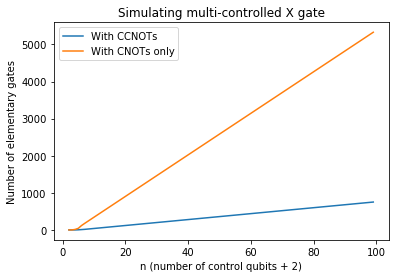

With CCNOTs Exact line is -40.00 + 8.00 * x.
With CNOTs only Exact line is -216.00 + 56.00 * x.


In [4]:
# Check linearity of simulating ∧_(n−2)(X) - as per chapter 7.1. 

dec1 = cgd.ControlledGateDecomposer(allow_toffoli=True)
dec2 = cgd.ControlledGateDecomposer(allow_toffoli=False)


def fit_exact_line(x, y, pos=10, label=""):
    a = (y[pos+1]-y[pos])/(x[pos+1]-x[pos])
    b = y[pos] - a * x[pos]
    for i in range(pos, len(x)):
        assert y[i] == a*x[i] + b
    print(label + " Exact line is %.02f + %.02f * x." % (b, a))

n_range = list(range(2, 100))
gates_count1 = []
gates_count2 = []
for n in n_range:
    qubits = cirq.LineQubit.range(n)
    gates1 = dec1.multi_ctrl_x(qubits[:-2], qubits[-1], free_qubits=[qubits[-2]])
    gates_count1.append(len(gates1))
    gates2 = dec2.multi_ctrl_x(qubits[:-2], qubits[-1], free_qubits=[qubits[-2]])
    gates_count2.append(len(gates2))
    
    assert (len(gates1) <= max(8*n-40, 10))
    assert (len(gates2) <= max(56*n-216, 44))
    
    
plt.plot(n_range, gates_count1, label='With CCNOTs')
plt.plot(n_range, gates_count2, label='With CNOTs only')
plt.xlabel('n (number of control qubits + 2)')
plt.ylabel('Number of elementary gates')
plt.title('Simulating multi-controlled X gate')
plt.legend()
plt.show()
fit_exact_line(n_range, gates_count1, label='With CCNOTs')
fit_exact_line(n_range, gates_count2, label='With CNOTs only')


## Testing unitary decomposition

In [5]:
# Test correctness of multi-controlled unitary decomposition.

np.random.seed(88)

ccnot_matrix = cirq.CCNOT._unitary_()
cnot_matrix = cirq.CNOT._unitary_()

def _random_unitary():
    return unitary_group.rvs(2)

def _random_special_unitary():
    U = _random_unitary()
    return U / np.sqrt(np.linalg.det(U))

def _validate_matrix(u, allow_toffoli=False):
    if u.shape == (2, 2):
        pass
    elif u.shape == (4, 4):
        assert np.allclose(u, cnot_matrix)
    elif u.shape == (8, 8):
        assert allow_toffoli and np.allclose(u, ccnot_matrix)
    else:
        raise AssertionError('Bad matrix shape')
        
def _test_decomposition_with(U, m, dec):
    qubits = cirq.LineQubit.range(m+1)

    gates = dec.decompose(U, qubits[:-1], qubits[-1])

    # Verify that all gates are either CNOT 1-qubit gates.
    for gate in gates:
        _validate_matrix(gate._unitary_(), dec.allow_toffoli)

    result_matrix = cirq.Circuit(gates).unitary()
    d = 2**(m+1)
    expected_matrix = np.eye(d, dtype=np.complex128)
    expected_matrix[d-2:d, d-2:d] = U
        
    assert np.allclose(expected_matrix, result_matrix)
    
def _test_decomposition(U, m):
    """Test decomposition with given 2x2 matrix and number of controls."""
    _test_decomposition_with(U, m, cgd.ControlledGateDecomposer(allow_toffoli=True))
    _test_decomposition_with(U, m, cgd.ControlledGateDecomposer(allow_toffoli=False))
    

for gate in [cirq.X, cirq.Y, cirq.Z, cirq.H, cirq.I, cirq.T]:
    for m in range(1, 7):
        _test_decomposition(gate._unitary_(), m)
print ("Specific matrices - OK")

for _ in range(10):
    U = unitary_group.rvs(2)
    for m in range(1, 6):
        _test_decomposition(U, m)
print ("Unitary matrices - OK")
    
for _ in range(10):
    U = _random_special_unitary()
    for m in range(1, 7):
        _test_decomposition(U, m)
print ("Special unitary matrices - OK")

U = _random_special_unitary()
for m in range(6, 9):
    _test_decomposition(U, m)
    print ("Special unitary, m=%d - OK" % m)
    
U = _random_unitary()
for m in range(6, 9):
    _test_decomposition(U, m)
    print ("Unitary, m=%d - OK" % m)    

Specific matrices - OK
Unitary matrices - OK
Special unitary matrices - OK
Special unitary, m=6 - OK
Special unitary, m=7 - OK
Special unitary, m=8 - OK
Unitary, m=6 - OK
Unitary, m=7 - OK
Unitary, m=8 - OK


In [6]:
def _decomp_size(U, controls_count, dec):
    qubits = cirq.LineQubit.range(controls_count+1)
    return len(dec.decompose(U, qubits[:controls_count], qubits[-1]))

# Test special unitary dec sizes - with toffoli
dec = cgd.ControlledGateDecomposer(allow_toffoli=True)
U = _random_special_unitary()
assert _decomp_size(U, 1, dec) == 7
assert _decomp_size(U, 2, dec) == 20
assert _decomp_size(U, 3, dec) == 20
assert _decomp_size(U, 4, dec) == 26
assert _decomp_size(U, 5, dec) == 38
for controls_count in range(6, 50):
    assert _decomp_size(U, controls_count, dec) == 16 * controls_count - 46
    
# Test special unitary dec sizes - without toffoli
dec = cgd.ControlledGateDecomposer(allow_toffoli=False)
U = _random_special_unitary()
assert _decomp_size(U, 1, dec) == 7
assert _decomp_size(U, 2, dec) == 20
assert _decomp_size(U, 3, dec) == 48
assert _decomp_size(U, 4, dec) == 106
assert _decomp_size(U, 5, dec) == 254
assert _decomp_size(U, 6, dec) == 370

for controls_count in range(6, 50):
    assert _decomp_size(U, controls_count, dec) == -302 + 112 * controls_count

In [7]:
# Test general unitary dec sizes - with toffoli
dec = cgd.ControlledGateDecomposer(allow_toffoli=True)

np.random.seed(3)
U = unitary_group.rvs(2)

assert _decomp_size(U, 1, dec) == 8
assert _decomp_size(U, 2, dec) == 26
assert _decomp_size(U, 3, dec) == 44
assert _decomp_size(U, 4, dec) == 68
assert _decomp_size(U, 5, dec) == 104
assert _decomp_size(U, 10, dec) == 476
assert _decomp_size(U, 20, dec) == 2264
assert _decomp_size(U, 30, dec) == 5419
assert _decomp_size(U, 40, dec) == 9623

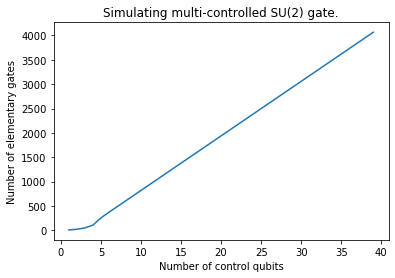

 Exact line is -302.00 + 112.00 * x.


In [8]:
# Check linearity of simulating multi-controlled SU gate. 

dec = cgd.ControlledGateDecomposer(allow_toffoli=False)

U = _random_special_unitary()
m_range = list(range(1, 40))
gates_count = []
for m in m_range:
    qubits = cirq.LineQubit.range(m+1)
    gates = dec.decompose(U, qubits[:-1], qubits[-1])
    gates_count.append(len(gates))
    
plt.plot(m_range, gates_count)
plt.xlabel('Number of control qubits')
plt.ylabel('Number of elementary gates')
plt.title('Simulating multi-controlled SU(2) gate.')
plt.show()
fit_exact_line(m_range, gates_count)

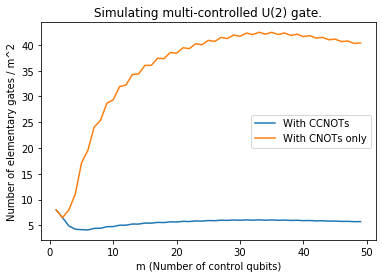

In [9]:
# Complexity of simulating multi-controlled general unitary gate. 

dec1 = cgd.ControlledGateDecomposer(allow_toffoli=True)
dec2 = cgd.ControlledGateDecomposer(allow_toffoli=False)

U = unitary_group.rvs(2)
m_range = list(range(1, 50))
gates_count_1 = []
gates_count_2 = []
for m in m_range:
    qubits = cirq.LineQubit.range(m+1)
    gates1 = dec1.decompose(U, qubits[:-1], qubits[-1])
    gates_count_1.append(len(gates1)/ (m**2))
    
    gates2 = dec2.decompose(U, qubits[:-1], qubits[-1])
    gates_count_2.append(len(gates2)/ (m**2))
    
    
plt.plot(m_range, gates_count_1, label='With CCNOTs')
plt.plot(m_range, gates_count_2, label='With CNOTs only')
plt.xlabel('m (Number of control qubits)')
plt.ylabel('Number of elementary gates / m^2')
plt.title('Simulating multi-controlled U(2) gate.')
plt.legend()
plt.show()